# Are some players more "clutch" than others?

Clutch time is defined as "the last 5 minutes of a game in which the point differential is 5 or less".
Do some players really rise to the challenge and perform better in the clutch?

To address this, we can use some `nba_api` functionality to get clutch stats and compare them to regular season stats. 
Due to the small sample size of clutch stats, we look at the total field goal percentage (total field goals made divided by total field goals attempted during clutch time).
However, for regular season stats, we look at the field goal percentage per game, averaged over all games.
This allows us to get a sense of the game-by-game variation of a player's field goal percentage

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import time
import ballDontLie 
from ballDontLie.util.api_nba import find_player_id
from nba_api.stats.endpoints import PlayerDashboardByClutch, PlayerGameLog, LeagueGameLog

## Sample players and data pull

We will examine some famous players, some thought to be more "clutch" than others.
Further, we look at these players season-by-season; in particular, their MVP seasons.
We could look into more than just their MVP seasons (some players didn't win an MVP that season but still had some very historical regular seasons or playoff runs).
Further, we could also expand to non-MVP players who have many clutch moments (Damian Lillard, Brandon Roy, among others)

In [6]:

players_mvps = {
    'Michael Jordan': ['1987-88', '1990-91', '1991-92', '1995-96', '1997-98'],
    'Kobe Bryant': ['2007-08'],
    'LeBron James': ['2008-09', '2009-10', '2011-12', '2012-13'], 
    'Kevin Durant': ['2013-14'],
    'Russell Westbrook': ['2016-17'],
    'Allen Iverson': ['2000-01'],
    'Stephen Curry': ['2014-15', '2015-16'],
    'Derrick Rose': ['2010-11'],
    'Steve Nash': ['2004-05', '2005-06']
}

Some constraints due to NBA stat recording, some years don't record clutch time stats, so we will have to account for the lack of data

In [18]:
df = pd.DataFrame()
for i, (player, mvp_seasons) in enumerate(players_mvps.items()):
    for mvp_season in mvp_seasons:
        print(player, mvp_season)
        player_id = find_player_id(player)[0]
        season_results = {'player': player, 
                          'player_id': player_id,
                         'season': mvp_season}

        regular_season_game_log = PlayerGameLog(player_id, season=mvp_season, 
                                                season_type_all_star='Regular Season')
        regular_season_clutch_games = PlayerDashboardByClutch(player_id, season=mvp_season, 
                                                              season_type_playoffs='Regular Season')

        season_results['regular_fg_pct'] = regular_season_game_log.get_data_frames()[0]['FG_PCT'].mean()
        season_results['regular_fg_pct_std'] = regular_season_game_log.get_data_frames()[0]['FG_PCT'].std()
        try:
            season_results['regular_clutch_fg_pct'] = (regular_season_clutch_games
                                           .last5_min_plus_minus5_point_player_dashboard
                                           .get_data_frame()['FG_PCT'].values[0])
        except IndexError:
            season_results['regular_clutch_fg_pct'] = -1.0

        playoffs_game_log = PlayerGameLog(player_id, season=mvp_season, 
                                                season_type_all_star='Playoffs')
        playoffs_clutch_games = PlayerDashboardByClutch(player_id, season=mvp_season, 
                                                              season_type_playoffs='Playoffs')

        season_results['playoff_fg_pct'] = playoffs_game_log.get_data_frames()[0]['FG_PCT'].mean()
        season_results['playoff_fg_pct_std'] = playoffs_game_log.get_data_frames()[0]['FG_PCT'].std()
        try:
            season_results['playoff_clutch_fg_pct'] = (playoffs_clutch_games
                                           .last5_min_plus_minus5_point_player_dashboard
                                           .get_data_frame()['FG_PCT'].values[0])
        except IndexError:
            season_results['playoff_clutch_fg_pct'] = -1.0
        summary_dict = {i: season_results}
        df = df.append(pd.DataFrame.from_dict(summary_dict, orient='index'))
        time.sleep(10)

Michael Jordan 1987-88
Michael Jordan 1990-91
Michael Jordan 1991-92
Michael Jordan 1995-96
Michael Jordan 1997-98
Kobe Bryant 2007-08
LeBron James 2008-09
LeBron James 2009-10
LeBron James 2011-12
LeBron James 2012-13
Kevin Durant 2013-14
Russell Westbrook 2016-17
Allen Iverson 2000-01
Stephen Curry 2014-15
Stephen Curry 2015-16
Derrick Rose 2010-11
Steve Nash 2004-05
Steve Nash 2005-06


Looking at the data, we have a somewhat neat dataframe of the players in their mvp seasons, and some information about their fg%.
Unfortunately, we're missing a lot of clutch information for Michael Jordan

In [19]:
df

,player,player_id,season,regular_fg_pct,regular_fg_pct_std,regular_clutch_fg_pct,playoff_fg_pct,playoff_fg_pct_std,playoff_clutch_fg_pct
0,Michael Jordan,893,1987-88,0.536207,0.100253,-1.000,0.526700,0.093797,-1.000
0,Michael Jordan,893,1990-91,0.543220,0.098105,-1.000,0.532059,0.105735,-1.000
0,Michael Jordan,893,1991-92,0.517175,0.098628,-1.000,0.496273,0.083527,-1.000
0,Michael Jordan,893,1995-96,0.494646,0.098950,-1.000,0.455333,0.104624,-1.000
0,Michael Jordan,893,1997-98,0.463866,0.100443,0.430,0.468381,0.087482,0.440
1,Kobe Bryant,977,2007-08,0.464744,0.110210,0.448,0.485619,0.102819,0.484
2,LeBron James,2544,2008-09,0.490827,0.099416,0.556,0.512929,0.100286,0.526
2,LeBron James,2544,2009-10,0.499855,0.086847,0.488,0.487182,0.139674,0.714
2,LeBron James,2544,2011-12,0.533387,0.111258,0.453,0.500000,0.094863,0.370
2,LeBron James,2544,2012-13,0.572526,0.114762,0.442,0.496000,0.120758,0.440


## Visualizing the results

We can plot the differences between the clutch fg% and the average fg% for each player's season.
If this number is above 0, then their clutch performances are better than their average performance.
Evaluating statistical significance can be estimated if this difference is larger than the standard deviation of the player's fg%.

### Regular season

Lebron, Russ, and AI are the only players to show a clutch fg% higher than their average fg%.
Unfortunately, these performance differences are very slight

### Playoffs

Lebron, KD, Steph, and DRose show clutch fg%s higher than their average playoff fg%

(-30, 30)

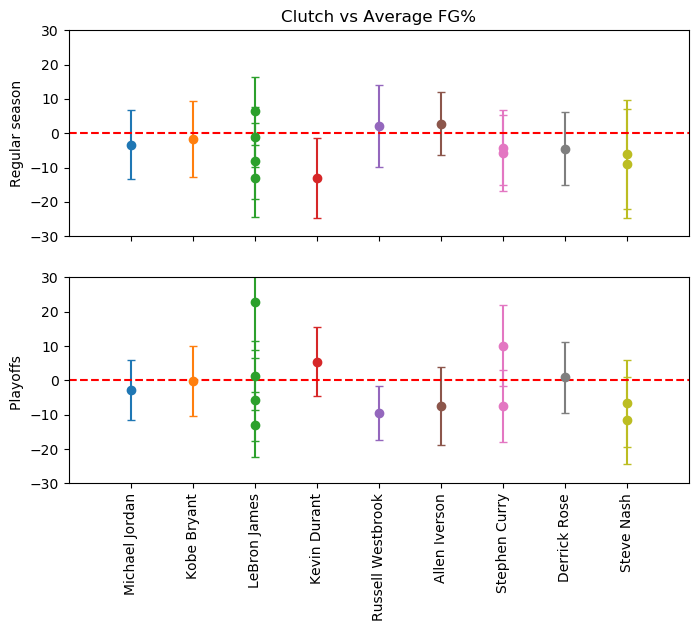

In [58]:
import itertools as it

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,6), dpi=100)
unique_players = df['player'].unique()
for i, player in enumerate(unique_players):
    sub_df = df[df['player']==player]
    ax[0].errorbar([i]*len(sub_df), 100*(sub_df['regular_clutch_fg_pct'] - sub_df['regular_fg_pct']),
                  yerr=100*sub_df['regular_fg_pct_std'], linestyle='', marker='o', capsize=3)
    ax[1].errorbar([i] * len(sub_df), 100*(sub_df['playoff_clutch_fg_pct'] - sub_df['playoff_fg_pct']),
                  yerr=100*sub_df['playoff_fg_pct_std'], linestyle='', marker='o', capsize=3)
    
ax[0].axhline(y=0, color='r', linestyle='--')
ax[1].axhline(y=0, color='r', linestyle='--')

ax[0].set_title("Clutch vs Average FG%")

ax[1].set_xlim([-1, len(unique_players)])
ax[1].set_xticks(np.arange(0, len(unique_players)))
ax[1].set_xticklabels(unique_players)
ax[1].xaxis.set_tick_params(rotation=90)


ax[0].set_ylabel("Regular season")
ax[1].set_ylabel("Playoffs ")
ax[0].set_ylim([-30, 30])
ax[1].set_ylim([-30, 30])




## Commentary on the analysis

It's not particularly fair to just take the difference between clutch fg% and average fg%.
During clutch time, it's usually assumed the team will put the ball in their best player's hands.
For these players we sampled, this will naturally lower their fg% because defenses are focusing more strongly on them, not necessarily the pressure of the moment getting to them.
Honestly, if your clutch fg% is the same as your average fg%, I'd be satisfied enough to call that player clutch.

It's also at least fun to confirm that superstars play worse in the playoffs (if you compare the two columns in the dataframe).
General concensus is that these players get guarded more tightly and schemed against, so their playoff fg% will be worse than regular season fg%.

To better evalaute "clutch", it might help to do this on a game-by-game basis.
If a player had a hot hand and cooled off during the clutch, that's bad.
If a player was cold and hit some big shots during the clutch, that's great.
In the manner conducted here, these game-by-game fluctuations are avoided and averaged out.
Looking at a more granular game-by-game method, we would witness more dramatic changes in a player's fg% from game to game and also that player's clutch fg% game to game (more noise in the data).

Averaging out all the game also eschews things like game severity/importance, the teams and players they were up against, and other important factors like the player-in-question's state of mind when they went into the game or the pressure of the moment.
For example, Lebron game 6 of the 2012 ECF was a very clutch performance (techincally not even during clutch time), but a performance like that just gets averaged out against all other games.
Other moments like losing 3-1 leads should be very anti-clutch performances, but those get averaged out.

## Conclusion

Yes, one could try to take a data-driven approach to study the clutch myth. 
At this day and age, there's some data for someone to try to build a case and argue for its validity.
However, I would argue there are still many "unquantifiables" that prohibit the clutch myth to truly be scrutinized with numbers.
All the complicated, "you had to be there", test-your-compsure moments demonstrate the limitations of data-driven analytics.